# Examen Data science 1
## 2023 - P4 - inhaalexamen

Naam: Gilles Claessens
Klas: INF107A
studentnummer: 0161096-76

In [3]:
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from id3 import Id3Estimator, export_text
from sklearn.cluster import KMeans
from sklearn import tree
import scipy.spatial.distance as dist
import warnings
import statistics

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score as r2score


class GeneralRegression:
    def __init__(self, degree=1, exp=False, log=False):
        self.degree = degree
        self.exp = exp
        self.log = log
        self.model = None
        self.x_orig = None
        self.y_orig = None
        self.X = None
        self.y = None

    def fit(self, x: np.array, y: np.array):
        self.x_orig = x
        self.y_orig = y
        self.X = x.reshape(-1, 1)

        if self.exp:
            self.y = np.log(y)

        else:
            self.y = y

        if self.log:
            self.X = np.log(self.X)

        self.model = make_pipeline(PolynomialFeatures(degree=self.degree), LinearRegression())
        self.model.fit(self.X, self.y)

    def predict(self, x: np.array):
        X = x.reshape(-1, 1)

        if self.exp:
            return np.exp(self.model.predict(X))

        if self.log:
            return self.model.predict(np.log(X))

        return self.model.predict(X)

    @property
    def r2_score(self):
        return r2score(self.y_orig, self.predict(self.x_orig))

    @property
    def se_(self):
        if self.exp:
            return mean_squared_error(self.predict(self.X), np.exp(self.y), squared=False)
        if self.log:
            return mean_squared_error(self.predict(self.X), np.log(self.y), squared=False)
        return mean_squared_error(self.predict(self.X), self.y, squared=False)

    @property
    def coef_(self):
        return self.model.steps[1][1].coef_

    @property
    def intercept_(self):
        return self.model.steps[1][1].intercept_

In [5]:
# Samenhang
def outlier_boundaries(x: pd.Series, factor=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    I = Q3 - Q1
    return [Q1 - factor * I, Q3 + factor * I]


def aantal_klassen(series):
    n = len(series)
    print("Sturges (# klassen): " + str(math.ceil(1 + math.log2(n))))  # Sturges
    b = 3.5 * statistics.stdev(series) / (n ** (1 / 3))
    print("Scott (klasse breedte): " + str(math.ceil((series.max() - series.min()) / b)))  # Scott
    print("Scott (# klassen): " + str(math.ceil(math.sqrt(n))))
    print("[√n]: " + str(math.ceil(math.sqrt(n))))


def makescatter(x, y):
    plt.scatter(x, y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()


def scatterWhitReg(X, y, se=0):  # Model moet aanwezig zijn
    fig, ax = plt.subplots()
    _ = ax.scatter(X, y)
    xx = np.arange(X.min(), X.max(), (X.max() - X.min()) / 100)
    yy = model.predict(xx.reshape(-1, 1))
    _ = ax.fill_between(xx, yy - se, yy + se, color="yellow", alpha=0.2)
    _ = ax.plot(xx, yy, color='red')
    _ = ax.set_xlabel(X.name)
    _ = ax.set_ylabel(y.name)
    plt.show()


def bestmodel(x, y):
    modelD1 = GeneralRegression(degree=1)
    modelD2 = GeneralRegression(degree=2)
    modelD3 = GeneralRegression(degree=3)
    modelL1 = GeneralRegression(degree=1, log=True)
    modelE1 = GeneralRegression(degree=1, exp=True)

    modelD1.fit(x.to_numpy(), y.to_numpy())
    modelD2.fit(x.to_numpy(), y.to_numpy())
    modelD3.fit(x.to_numpy(), y.to_numpy())
    modelL1.fit(x.to_numpy(), y.to_numpy())
    modelE1.fit(x.to_numpy(), y.to_numpy())
    out = pd.Series(data=[modelD1.r2_score, modelD2.r2_score, modelD3.r2_score, modelL1.r2_score, modelE1.r2_score],
                    index=["lineair:", "kwadratisch:", "kubisch:", "logaritmisch", "exponentieel"])
    return out.sort_values(ascending=False)


def drop_outliers(df, row):  # df = drop_uitschieters(df,'row')
    df['Z-Score'] = np.abs((df[row] - df[row].mean()) / df[row].std())
    filtered_df = df[df['Z-Score'] <= 3]
    filtered_df = filtered_df.drop('Z-Score', axis=1)
    return filtered_df


# Forecasting
def autocorrDia(x):
    plt.figure()
    plot_acf(np.array(x).astype(float), lags=len(x) - 1)
    plt.xlabel('offset')
    plt.ylabel('correlatie')
    plt.title(f'Auto-correlatie {x.name}')
    plt.show()


def smooth(y: np.array, m: int):
    result = np.empty(0)
    for i in range(y.size - m + 1):
        result = np.append(result, [np.mean(y[i:i + m])])

    return result


def find_trend(y: np.array, m: int):
    result = smooth(y, m)
    nan = [np.nan] * int(m / 2)
    if m % 2 == 0:
        result = smooth(result, 2)
        result = np.hstack([nan, result, nan])

    return result


def naive(y: np.array):
    if y.size > 0:
        return y[-1]
    return np.NaN


def plotforecast(original: np.array, voorspeldd: np.array):
    plt.figure()
    plt.plot(range(len(original)), original, "o-", label="gegeven")
    plt.plot(range(len(original), len(original) + len(voorspeldd)), voorspeldd, "^-", label="voorspeld")
    plt.show()


def forecast_past(past, forecast_function):
    result = []
    for i in range(len(past)):
        result += [forecast_function(past[:i].to_numpy())]
    return result


def mae(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return errors.abs().mean()


def rmse(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return math.sqrt((errors ** 2).mean())


def mape(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return (errors / past).abs().mean()


def betrw(X: np.array, y):
    return pd.Series(data=[mae(X, y), rmse(X, y), mape(X, y)], index=['mae', 'rmse', 'mape'])


def average(y: np.array):
    if y.size < 1:
        return np.NaN
    return y.mean()


def moving_average_forecasting(m):
    def result(past):
        n = len(past)
        if n < m:
            return math.nan
        return pd.Series(past[-m:]).mean()

    return result


def bereken_gewichten(y: np.array, m: int):
    # n is aantal elementen
    n = y.size
    # we hebben > 2 * m elementen nodig
    if n < 2 * m:
        return np.NaN
    # selecteer de laatste elementen
    M = y[-(m + 1):-1]
    # maak een matrix M van coëfficiënten
    for i in range(1, m):
        M = np.vstack([M, y[-(m + i + 1):-(i + 1)]])

    # selecteer de bekenden
    v = np.flip(y[-m:])
    # los het stelsel van m vergelijkingen op
    return np.linalg.solve(M, v)


def lineair_combination_forecasting(m):
    def result(past):
        n = len(past)
        if n < 2 * m:
            return math.nan
        a = bereken_gewichten(past, m)
        return (past[-m:] * a).sum()

    return result


def create_trend_model(y):
    X = np.arange(0, y.size)
    model = GeneralRegression()
    model.fit(X, y)
    # we geven een voorspellersfunctie terug
    return lambda x: model.predict(np.array(x))
    # return model


def general_regression(x: pd.Series, y: pd.Series, degree=1, exp=False, log=False):
    fun_y = inv_fun_y = lambda x: x
    fun_x = lambda x: x
    if (exp):
        fun_y = np.exp
        inv_fun_y = np.log
    if (log):
        fun_x = np.log
    model = np.polyfit(fun_x(x), inv_fun_y(y), degree)
    line = np.poly1d(model)
    predict = lambda x: fun_y(line(fun_x(x)))
    predicted = predict(x)
    squared_residuals = (predicted - y) ** 2
    variance_y = (y - y.mean()) ** 2
    se = math.sqrt(squared_residuals.mean())
    r2 = 1 - (squared_residuals.sum() / variance_y.sum())
    result = [se, r2, predict] + [model[-i] for i in range(1, len(model) + 1)]
    index = ["se", "r2", "predict"] + [chr(i + 96) for i in range(1, len(model) + 1)]
    return pd.Series(result, index=index)


# Clustering
def afstand_euclidisch(tabel, i, j):
    rij1 = tabel.iloc[i]
    rij2 = tabel.iloc[j]
    afstand = math.sqrt(((rij1 - rij2) ** 2).sum())
    return round(afstand, 2)


def afstand_manhattan(tabel, i, j):
    rij1 = tabel.iloc[i]
    rij2 = tabel.iloc[j]
    afstand = ((rij1 - rij2).abs()).sum()
    return afstand


def all(df, funcanfstand):
    lengte = df.shape[1]
    aaltalrows = df.shape[0]
    out = pd.DataFrame()
    for x in range(aaltalrows - 1):
        row = []
        for y in range(aaltalrows - 1):
            row += [funcanfstand(df, x, y)]
        out[x] = row
    return out


# PCA
# Beslissingsbomen
def entropy(column: pd.Series, base=None):
    # Determine the fractions for all column values
    fractions = column.value_counts(normalize=True, sort=False)
    base = 2 if base is None else base
    return -(fractions * np.log(fractions) / np.log(base)).sum()


def information_gain(df: pd.DataFrame, s: str, target: str):
    # calculate entropy of parent table
    entropy_parent = entropy(df[target])
    child_entropies = []
    child_weights = []
    # compute entropies of child tables
    for (label, p) in df[s].value_counts().items():
        child_df = df[df[s] == label]
        child_entropies.append(entropy(child_df[target]))
        child_weights.append(int(p))
    # calculate the difference between parent entropy and weighted child entropies
    return entropy_parent - np.average(child_entropies, weights=child_weights)


def infGainAll(df, target):
    out = pd.Series()
    for label in df.columns:
        line = pd.Series([information_gain(df, label, target)], index=[label])
        out = pd.concat([out, line])
        # print('{}: {}'.format(label, ))
    return out.sort_values(ascending=False)


def best_split(df: pd.DataFrame, target: str):
    # retrieve all non-target column labels (the features))
    features = df.drop(axis=1, labels=target).columns
    # calculate the information gains for these features
    gains = [information_gain(df, feature, target) for feature in features]
    # return column with highest information gain
    return features[np.argmax(gains)], max(gains)


Hier staat code om het bestand in te lezen.  Pas eventueel het path aan.  De rest van de code zou zo moeten werken:

In [89]:
# voorgeschreven code
examen = pd.read_csv('examen_2023_P4_inhaal.csv')
examen.opinie = pd.Categorical(examen.opinie, categories=('zeer mee oneens', 'mee oneens', 'neutraal', 'mee eens', 'zeer mee eens'), ordered=True)
examen.categorie = pd.Categorical(examen.categorie, categories=('cat1 (klein)', 'cat2 (middel)', 'cat3 (groot)'), ordered=True)
examen.behaalde_graad = pd.Categorical(examen.behaalde_graad, categories=('gebuisd', 'voldoening', 'onderscheiding', 'grote onderscheiding', 'grootste onderscheiding'), ordered=True)
examen.kledingmaat = pd.Categorical(examen.kledingmaat, categories=('XS', 'S', 'M', 'L', 'XL', 'XXL'), ordered=True)
examen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   werknemersId        60 non-null     int64   
 1   waardering          60 non-null     int64   
 2   opinie              60 non-null     category
 3   aantal_gezinsleden  60 non-null     float64 
 4   diepte              60 non-null     float64 
 5   oplaadtijd          60 non-null     float64 
 6   beltijd             60 non-null     float64 
 7   concentratie        60 non-null     float64 
 8   afstand             60 non-null     float64 
 9   categorie           60 non-null     category
 10  behaalde_graad      60 non-null     category
 11  kledingmaat         60 non-null     category
 12  aantal_gsms         60 non-null     float64 
dtypes: category(4), float64(7), int64(2)
memory usage: 5.3 KB


## Vraag 1

Antwoorden:
a) Methode van Kendall
b) -0.4229341994306363
c) C (Zeer sterke lineaire correlatie)
d) -0.9198975712194224
e) Ja, er is namelijk een zeer hoge correlatie tussen de twee kolommen.

In [86]:
# B
examen.opinie.corr(examen.waardering,method='kendall')
# D
examen.beltijd.corr(examen.aantal_gezinsleden)

-0.9198975712194224

## Vraag 2

Antwoorden:
a) y = -1.605540441631062 * x + 0.03208181800418398
b) 3.52755
c) 0.9552629612424209
d) B
e) 0.2958429799727267
f) D

In [87]:
# A
model = GeneralRegression(degree=1)
model.fit(examen.beltijd.to_numpy(),examen.diepte.to_numpy())
print(f'y= {model.intercept_}*x + {model.coef_[1]}')

# B
model.predict(np.array([160]))

#C
print(model.se_)

#E
model = GeneralRegression(degree=1,exp=True)
model.fit(examen.concentratie.to_numpy(),examen.oplaadtijd.to_numpy())
print(model.r2_score)

y= -1.605540441631062*x + 0.03208181800418398
0.9552629612424209
0.2958429799727267


## Vraag 3

Antwoorden:
a) 231.4
b) 217.28333333333333
c) MAPE: 0.032117
d) A (Voorspelling wijkt 3,21% af van de echte waarde.)
e) Alle waarden zijn over het algemeen zeer gecorreleerd maar om de 10 waardes toch een kleine piek.
f) -0.93
g) Op indices 3, 13, 23, 33, 43, 53

[231.4]
217.28333333333333
mae     6.230864
rmse    8.463272
mape    0.032117
dtype: float64


<Figure size 640x480 with 0 Axes>

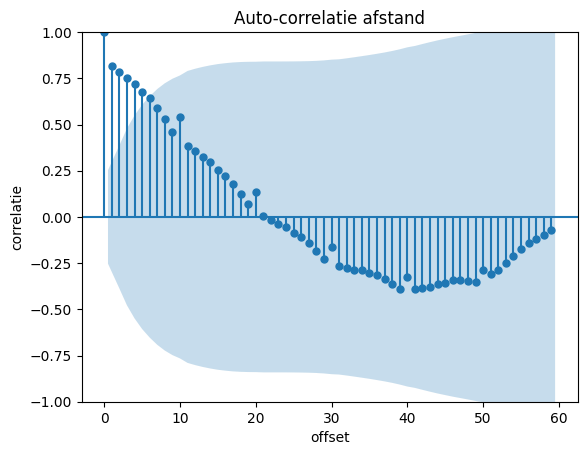

0    -0.62
1     0.27
2     0.17
3    -0.93
4     0.77
5    -0.09
6    -0.39
7    -0.29
8     0.61
9     0.50
10   -0.62
11    0.27
12    0.17
13   -0.93
14    0.77
15   -0.09
16   -0.39
17   -0.29
18    0.61
19    0.50
20   -0.62
21    0.27
22    0.17
23   -0.93
24    0.77
25   -0.09
26   -0.39
27   -0.29
28    0.61
29    0.50
30   -0.62
31    0.27
32    0.17
33   -0.93
34    0.77
35   -0.09
36   -0.39
37   -0.29
38    0.61
39    0.50
40   -0.62
41    0.27
42    0.17
43   -0.93
44    0.77
45   -0.09
46   -0.39
47   -0.29
48    0.61
49    0.50
50   -0.62
51    0.27
52    0.17
53   -0.93
54    0.77
55   -0.09
56   -0.39
57   -0.29
58    0.61
59    0.50
Name: seasonal, dtype: float64
Index([3, 13, 23, 33, 43, 53], dtype='int64')


In [34]:
# A: Naive berekenen (Eerstvolgende waarde)
verleden = examen.afstand.to_numpy()
voorspeld = np.empty(shape=0)
for i in range(1):
    volgende = naive(verleden)
    voorspeld = np.append(voorspeld, volgende)
    verleden = np.append(verleden, volgende)
print(voorspeld)

# B
x = moving_average_forecasting(m=6)
print(x(examen.afstand))

# C
print(betrw(examen.afstand, moving_average_forecasting(6)))

# E
autocorrDia(examen.afstand)

# F
sd_model = seasonal_decompose(examen.aantal_gsms, model='additieve', period=10)
print(sd_model.seasonal)

# G
y = sd_model.seasonal[sd_model.seasonal == min(sd_model.seasonal)]
print(y.index)

## Vraag 4

Antwoorden:
a) 2.1332540670788203
b) Kledingmaat
c) 0.2991407412289808
d) Meetniveau ratio
e) zie code
f) Grootste onderscheiding

In [78]:
# voorgeschreven code
examen2 = examen[['categorie', 'behaalde_graad', 'kledingmaat']]
examen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   categorie       60 non-null     category
 1   behaalde_graad  60 non-null     category
 2   kledingmaat     60 non-null     category
dtypes: category(3)
memory usage: 876.0 bytes
2.0744658394793376


In [36]:
# voorgeschreven code
examen3 = examen[['diepte', 'oplaadtijd', 'aantal_gsms']]
examen3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diepte       60 non-null     float64
 1   oplaadtijd   60 non-null     float64
 2   aantal_gsms  60 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


In [93]:
# A
total = len(examen2)
print(entropy(examen.waardering))
# B
best_split(examen2,'behaalde_graad')

# E
model = Id3Estimator(max_depth=3)
x = examen3.values.tolist()
y = examen.behaalde_graad.values.tolist()
model.fit(x,y)
print(export_text(model.tree_, feature_names=examen3.columns))

# F
print(f"Resultaat voorpselling: {model.predict([[2,1.4,140]])}")

2.1332540670788203

diepte <=4.85
|   aantal_gsms <=6.50
|   |   oplaadtijd <=160.85: grootste onderscheiding (4/4) 
|   |   oplaadtijd >160.85: grootste onderscheiding (18/26) 
|   aantal_gsms >6.50: grootste onderscheiding (4) 
diepte >4.85
|   aantal_gsms <=2.50: gebuisd (2) 
|   aantal_gsms >2.50
|   |   oplaadtijd <=153.75: grootste onderscheiding (1) 
|   |   oplaadtijd >153.75: voldoening (1) 

Resultaat voorpselling: ['grootste onderscheiding']


H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in lo

## Vraag 5

Antwoorden:
a) 6.85 (Rijnummer indexes 5 & 0) of 20.4 (Rijnummers 6 & 1)
b) Cluster 1: 59 rijen & Cluster 2: 1 rij
c) Cluster 1: 21 rijen & Cluster 2: 29 rijen & Cluster 3: 10


In [46]:
# voorgeschreven code
examen4 = examen[['diepte', 'oplaadtijd', 'aantal_gsms']]
examen4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diepte       60 non-null     float64
 1   oplaadtijd   60 non-null     float64
 2   aantal_gsms  60 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


In [65]:
# A (Index of rijnummer?)
print("Vraag A:")
print(afstand_euclidisch(examen4, 6, 1)) # Rijnummers
print(afstand_euclidisch(examen4, 5, 0)) # Rij indexes

# B
from sklearn.cluster import AgglomerativeClustering
hcmodel = AgglomerativeClustering(linkage='single', affinity = 'manhattan', n_clusters=2)
hcmodel.fit(examen4)
df = pd.Series(hcmodel.labels_)

print("\nVraag B:")
print(f"Cluster 1: {df[df == 0].count()}")
print(f"Cluster 2: {df[df == 1].count()}")

# C
print("\nVraag C:")
model = KMeans(n_clusters=3)
model.fit(examen4)
series2 = pd.Series(model.labels_)
print(f"Cluster 1: {series2[series2 == 0].count()}")
print(f"Cluster 2: {series2[series2 == 1].count()}")
print(f"Cluster 3: {series2[series2 == 2].count()}")

Vraag A:
20.4
6.85

Vraag B:
Cluster 1: 59
Cluster 2: 1

Vraag C:
Cluster 1: 21
Cluster 2: 29
Cluster 3: 10


H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
H:\My Drive\School\2022-2023\Data-Science\Data-Science\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Vraag 6

Antwoorden:
a) Enkel de kolommen met meetniveau ratio (aantal_gezinsleden, oplaadtijd, beltijd, concentratie, afstand, aantal_gsms)
b) Zie code (variabele df)
c) 76.12%
d) Eerste 2 hoofdcomponenten behouden zo'n 76.12% van originele data.
e) /

In [76]:
# A
print(examen.info())

# B
df = pd.DataFrame({"aantal_gezinsleden" : examen.aantal_gezinsleden, "oplaadtijd" : examen.oplaadtijd, "beltijd" : examen.beltijd, "concentratie" : examen.concentratie, "afstand" : examen.afstand, "aantal_gsms" : examen.aantal_gsms})

# C
from sklearn.decomposition import PCA

pca_dim = min(df.shape[1], df.shape[0])
pcamodel = PCA(pca_dim)
principalComponents = pcamodel.fit_transform(df)

print('Verklaarde variantie:', pcamodel.explained_variance_ratio_)
print('Verklaarde cum. variantie:', np.cumsum(np.round(pcamodel.explained_variance_ratio_, decimals=4)*100))

# E
#/

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   werknemersId        60 non-null     int64   
 1   waardering          60 non-null     int64   
 2   opinie              60 non-null     category
 3   aantal_gezinsleden  60 non-null     float64 
 4   diepte              60 non-null     float64 
 5   oplaadtijd          60 non-null     float64 
 6   beltijd             60 non-null     float64 
 7   concentratie        60 non-null     float64 
 8   afstand             60 non-null     float64 
 9   categorie           60 non-null     category
 10  behaalde_graad      60 non-null     category
 11  kledingmaat         60 non-null     category
 12  aantal_gsms         60 non-null     float64 
dtypes: category(4), float64(7), int64(2)
memory usage: 5.3 KB
None
Verklaarde variantie: [4.35436557e-01 3.25828874e-01 2.23862860e-01 1.43525396e